# Supply Chain Management – Delivery & Quantity Risk Modeling

This notebook demonstrates the end-to-end analysis pipeline for identifying
delivery and quantity risks in procurement data.

It is designed as a **reproducible entry point** for the open-source project:
- Data cleaning & anomaly labeling
- Exploratory analysis and visualization
- Feature engineering
- Machine learning models for delivery and quantity risk
- Model interpretability using SHAP

> Note: The original datasets are confidential and are not included in this repository.
> This notebook assumes compatible datasets placed under `data/raw/`.

In [ ]:
# Core
import os
import sys
from pathlib import Path

# Data & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import importlib

# Silence warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Allow importing from src/
repo_root = Path("..").resolve()
sys.path.append(str(repo_root))

In [3]:
from src.config import build_paths, ensure_dirs
from src.io import load_company_data
from src.cleaning import clean_data
from src.labeling import add_comment_column, add_labels
from src.features import (
    basic_feature_engineering,
    extended_feature_engineering_delivery,
    feature_engineering_quantity
)
from src.visualization import (
    compare_missing_zero_counts,
    plot_special_orders,
    delivery_delay_comparison,
    supplier_performance_analysis
)
from src.models import (
    filter_train_data_for_delivery,
    filter_train_data_for_quantity,
    evaluate_all_models,
    save_model
)
from src.explain import shap_summary_bar
from src.predict import predict_single_order

In [4]:
# Build standardized project paths
paths = build_paths(repo_root)
ensure_dirs(paths)

# Expected data locations (user must provide their own data)
A_FILE = paths.data_dir / "raw" / "company_a.csv"
B_FILE = paths.data_dir / "raw" / "company_b.csv"

print("Company A file:", A_FILE)
print("Company B file:", B_FILE)

Company A file: C:\Users\15899\Documents\GitHub\supply-chain-management\data\raw\company_a.csv
Company B file: C:\Users\15899\Documents\GitHub\supply-chain-management\data\raw\company_b.csv


In [5]:
# Load datasets
df_a, df_b = load_company_data(A_FILE, B_FILE, sep=";")

print("Company A shape:", df_a.shape)
print("Company B shape:", df_b.shape)

df_a.head()

Company A shape: (9194, 11)
Company B shape: (18078, 12)


,Order Number,Order Position,Supplier,Ordered Product,Product Article Number,End Product,Planned Delivery Date,Arrival Date,Ordered Quantity,Delivered Quantity,Quality
0,74682,11,41781068,V-Flansch,3000.0,NaN,2023-01-05,2022-12-15,3.0,3.0,3.1
1,74682,11,41781068,V-Flansch,3000.0,NaN,2023-01-05,2022-12-15,3.0,3.0,3.1
2,74682,11,41781068,V-Flansch,3000.0,NaN,2023-01-05,2022-12-15,3.0,3.0,3.1
3,74682,14,41781068,WN-Flansch,3500.0,NaN,2023-01-05,2022-12-15,2.0,2.0,3.1
4,74682,14,41781068,WN-Flansch,3500.0,NaN,2023-01-05,2022-12-15,2.0,2.0,3.1


In [6]:
# Cleaning
df_a = clean_data(df_a)
df_b = clean_data(df_b)

# Anomaly comments
df_a = add_comment_column(df_a)
df_b = add_comment_column(df_b)

# Labels
df_a = add_labels(df_a, delivery_threshold=1)
df_b = add_labels(df_b, delivery_threshold=1)

# Basic features
df_a = basic_feature_engineering(df_a)
df_b = basic_feature_engineering(df_b)

df_a[["delivery_status", "quantity_status"]].value_counts()

delivery_status  quantity_status
Late             Correct            2843
On-time          Correct            1750
Early            Correct            1645
Late             Less                 33
On-time          Less                 11
Early            Less                  8
Late             More                  7
Early            More                  2
On-time          More                  2
Name: count, dtype: int64

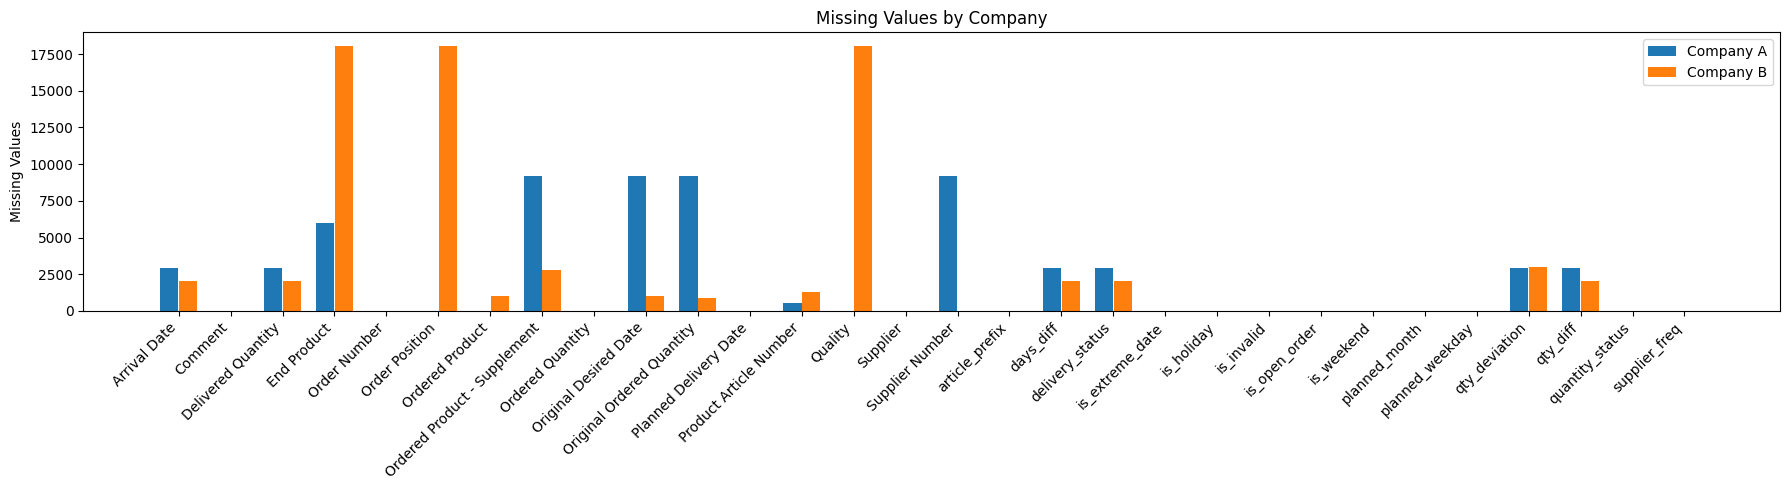

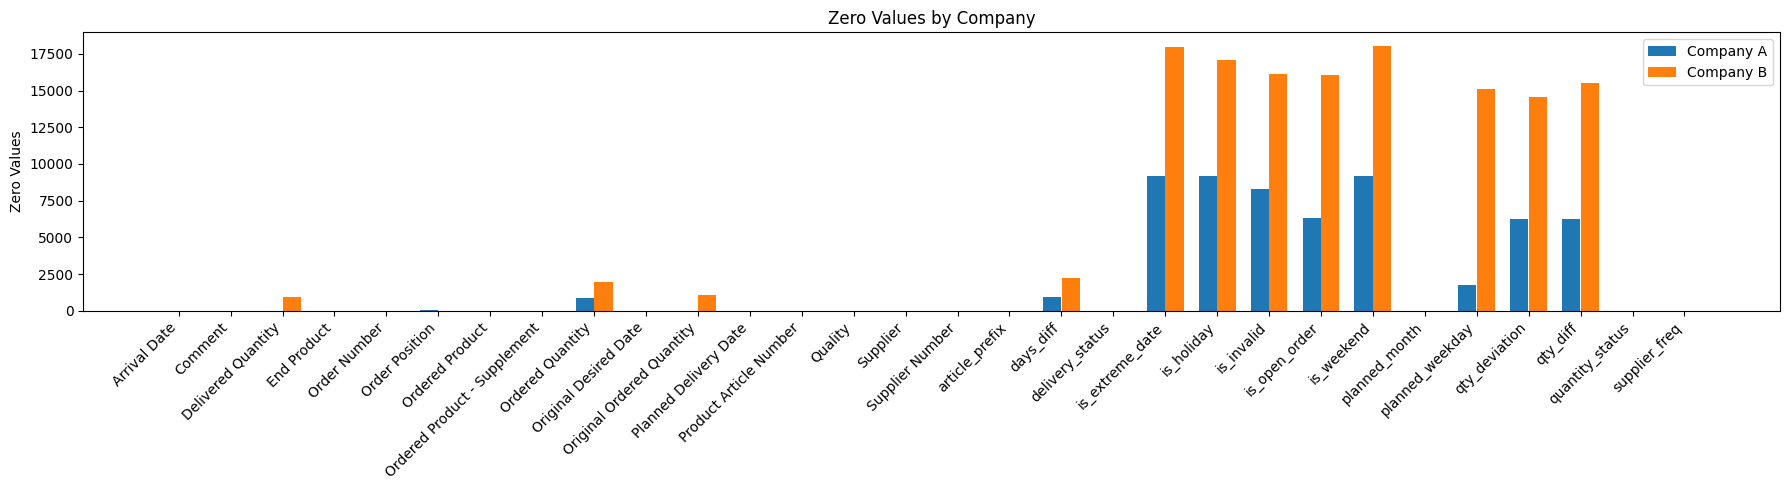

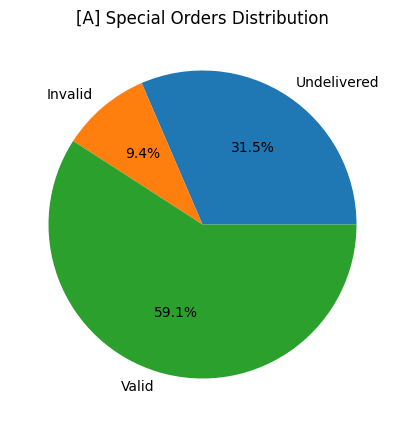

[A] Undelivered: 2893 | Invalid: 865 | Total: 9194


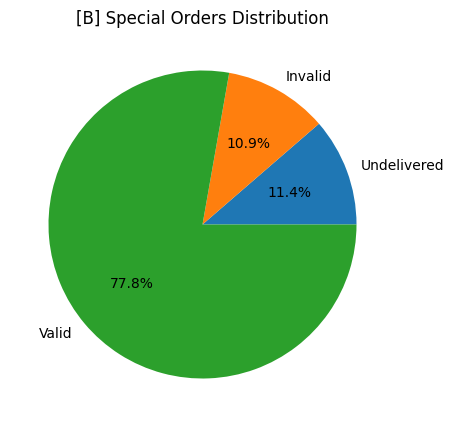

[B] Undelivered: 2052 | Invalid: 1966 | Total: 18078
[A] Abnormal date ratio (<2017 or >2027 or missing): 0.00%
[A] After filtering abnormal dates and outlier delays: 6269 records remain (68.19% of total)


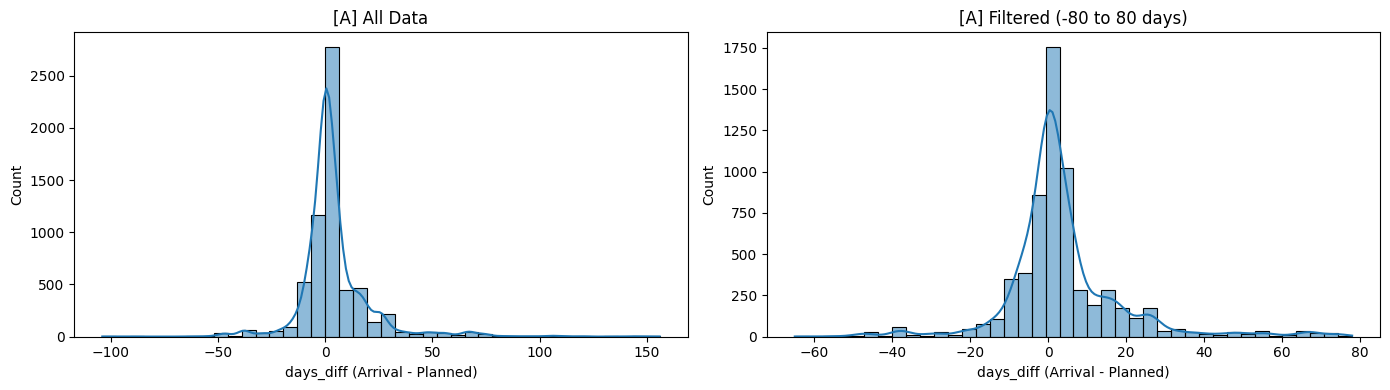

[B] Abnormal date ratio (<2017 or >2027 or missing): 0.63%
[B] After filtering abnormal dates and outlier delays: 15506 records remain (85.77% of total)


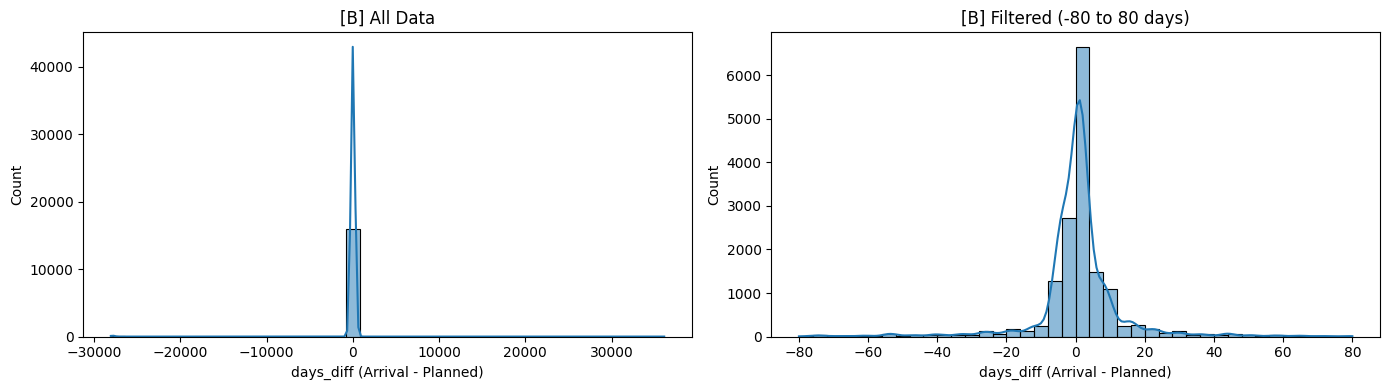

In [7]:
# Missing & zero analysis
compare_missing_zero_counts(df_a, df_b)

# Special orders
plot_special_orders(df_a, "A")
plot_special_orders(df_b, "B")

# Delivery delay distributions
delivery_delay_comparison(df_a, "A")
delivery_delay_comparison(df_b, "B")

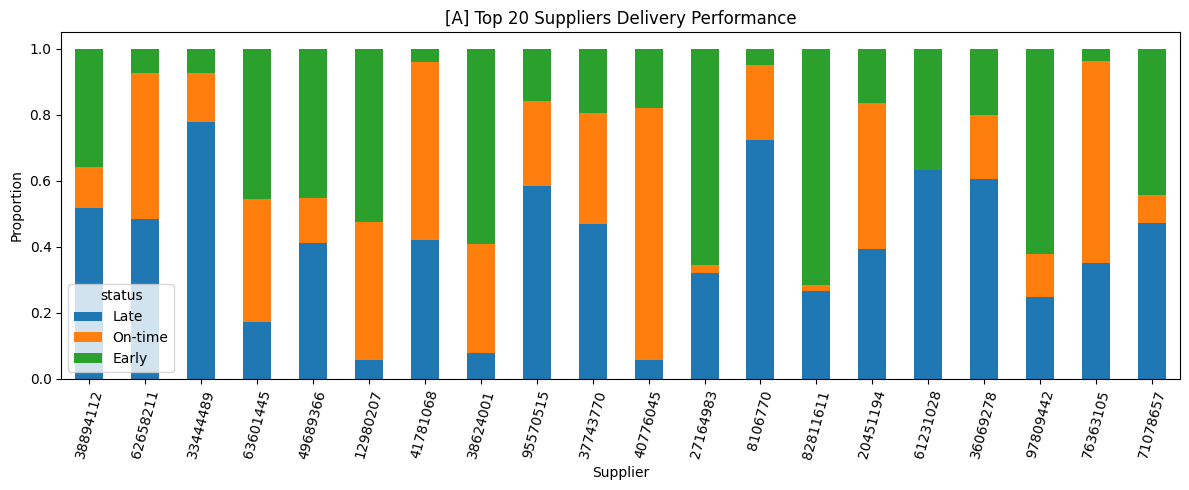


[A] High-risk suppliers (on-time = 0%, orders >= 10): 19
[A] Best suppliers (on-time = 100%, orders >= 10): 5


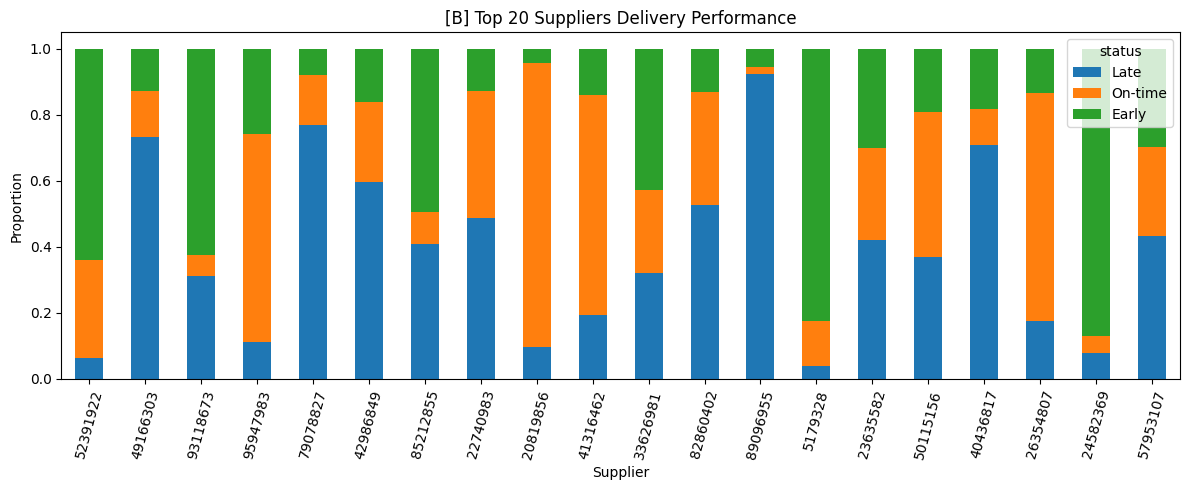


[B] High-risk suppliers (late = 100%, orders >= 10): 7
[B] Best suppliers (late = 0%, orders >= 10): 8


In [8]:
supplier_stats_a = supplier_performance_analysis(df_a, "A")
supplier_stats_b = supplier_performance_analysis(df_b, "B")

In [9]:
# Extended features for delivery modeling
df_a_fe = extended_feature_engineering_delivery(df_a)
df_b_fe = extended_feature_engineering_delivery(df_b)

# Training sets
train_a_delivery = filter_train_data_for_delivery(df_a_fe)
train_b_delivery = filter_train_data_for_delivery(df_b_fe)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# Define Models
delivery_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs=-1),
    "LightGBM": LGBMClassifier(class_weight="balanced", n_jobs=-1, verbose=-1),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", n_jobs=-1),
    "CatBoost": CatBoostClassifier(verbose=0, allow_writing_files=False)
}

# Define Features
features_delivery = [
    "Ordered Quantity", "planned_month", "planned_weekday",
    "is_weekend", "is_holiday", "supplier_freq",
    "supplier_delay_mean", "supplier_late_rate"
]

# Create X and y
# CRITICAL FIX: .astype(float) converts Booleans (True/False) to 1.0/0.0
# This prevents errors in XGBoost/LightGBM which may not support boolean types directly.
X_a = train_a_delivery[features_delivery].fillna(0).astype(float)
y_a = train_a_delivery["delivery_status"]

# Run Evaluation
best_a_delivery = evaluate_all_models(
    delivery_models, 
    X_a, 
    y_a,
    company="Company A",
    taskname="Delivery Status",
    stratified=False
)


====== Company A - Delivery Status (5-Fold CV macro-F1) [SMOTE=False] ======
Logistic Regression: 0.547
Random Forest: 0.872
LightGBM: 0.857
XGBoost: 0.867
CatBoost: 0.858

>> Best Model for Company A Delivery Status: Random Forest (F1=0.872)

Company A Delivery Status (Random Forest) - Classification Report
              precision    recall  f1-score   support

       Early      0.841     0.864     0.852       331
        Late      0.917     0.890     0.904       574
     On-time      0.847     0.866     0.857       352

    accuracy                          0.877      1257
   macro avg      0.869     0.874     0.871      1257
weighted avg      0.878     0.877     0.877      1257

Accuracy: 0.877
Confusion Matrix:
 [[286  24  21]
 [ 29 511  34]
 [ 25  22 305]]


In [11]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier  

# Data preparation
if 'df_a' in locals():
    print("Generating train_a_quantity from df_a...")
    df_a_qty_fe = feature_engineering_quantity(df_a)
    train_a_quantity = filter_train_data_for_quantity(df_a_qty_fe)
    print(f"train_a_quantity ready. Shape: {train_a_quantity.shape}")
else:
    raise NameError("df_a is not defined. Please run the 'Load Datasets' cell at the top first.")

# Define Models
quantity_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs=-1),
    "LightGBM": LGBMClassifier(class_weight="balanced", n_jobs=-1, verbose=-1),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", n_jobs=-1),
    "CatBoost": CatBoostClassifier(verbose=0, allow_writing_files=False, iterations=75)
}

# Prepare features and data
features_quantity = [
    "Ordered Quantity", "planned_month", "planned_weekday",
    "is_weekend", "is_holiday", "supplier_freq",
    "supplier_quantity_deviation_mean"
]

X_raw = train_a_quantity[features_quantity].fillna(0).astype(float)
y_raw = train_a_quantity["quantity_status"]

print("Original sample distribution:", Counter(y_raw))


# Execute a global SMOTE, force k_neighbors=1 to accommodate very few samples
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_raw, y_raw)

print("Oversampled sample distribution:", Counter(y_resampled))

# Run Evaluation
best_a_quantity_global = evaluate_all_models(
    quantity_models, 
    X_resampled, 
    y_resampled,
    company="Company A (Global SMOTE)",
    taskname="Quantity Accuracy",
    stratified=True,
    use_smote=False 
)

Generating train_a_quantity from df_a...
train_a_quantity ready. Shape: (6285, 28)
Original sample distribution: Counter({'Correct': 6222, 'Less': 52, 'More': 11})
Oversampled sample distribution: Counter({'Correct': 6222, 'Less': 6222, 'More': 6222})

====== Company A (Global SMOTE) - Quantity Accuracy (5-Fold CV macro-F1) [SMOTE=False] ======
Logistic Regression: 0.670
Random Forest: 0.998
LightGBM: 0.998
XGBoost: 0.998
CatBoost: 0.997

>> Best Model for Company A (Global SMOTE) Quantity Accuracy: XGBoost (F1=0.998)

Company A (Global SMOTE) Quantity Accuracy (XGBoost) - Classification Report
              precision    recall  f1-score   support

     Correct      0.996     0.992     0.994      1244
        Less      0.994     0.997     0.996      1245
        More      0.998     0.999     0.998      1245

    accuracy                          0.996      3734
   macro avg      0.996     0.996     0.996      3734
weighted avg      0.996     0.996     0.996      3734

Accuracy: 0.996
C

In [ ]:
# ========== Save the best model ==========
# Dynamically build the save path
MODEL_DIR = repo_root / "outputs" / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f" Model save directory prepared: {MODEL_DIR}")

# --- Save Company A Delivery Model ---
if 'best_a_delivery' in locals():
    print("Saving Company A Delivery Model...")
    
    # Fix NameError: Re-extract data from train_a_delivery
    # Ensure we are using the correct feature list
    features_delivery = [
        "Ordered Quantity", "planned_month", "planned_weekday",
        "is_weekend", "is_holiday", "supplier_freq",
        "supplier_delay_mean", "supplier_late_rate"
    ]
    
    # Regenerate X and y to ensure variables exist
    if 'train_a_delivery' in locals():
        X_a_delivery = train_a_delivery[features_delivery].fillna(0).astype(float)
        y_a_delivery = train_a_delivery["delivery_status"]
    else:
        # If train_a_delivery is missing, try using previously defined X_a, y_a
        print(" train_a_delivery not found, trying X_a and y_a...")
        X_a_delivery = X_a
        y_a_delivery = y_a

    # Get the champion model and label encoder
    model_a_del = best_a_delivery["best_model"]
    le_a_del = best_a_delivery["label_encoder"]
    
    # Retrain on the full dataset
    # Note: Must transform y using label_encoder first
    y_a_del_enc = le_a_del.transform(y_a_delivery)
    model_a_del.fit(X_a_delivery, y_a_del_enc)
    
    # Save model and encoder
    joblib.dump(model_a_del, MODEL_DIR / 'best_a_delivery.pkl')
    joblib.dump(le_a_del, MODEL_DIR / 'le_a_delivery.pkl') 
    print(f" Company A Delivery Model saved to: {MODEL_DIR / 'best_a_delivery.pkl'}")


# --- Save Company A Quantity Model (Global SMOTE Version) ---
if 'best_a_quantity_global' in locals():
    print("Saving Company A Quantity Model...")
    
    # Get the champion model and label encoder
    model_a_qty = best_a_quantity_global["best_model"]
    le_a_qty = best_a_quantity_global["label_encoder"]
    
    # Critical Fix: Convert string labels to numeric labels first
    # y_resampled contains strings ['Correct', 'Less', ...], must convert to [0, 1, ...]
    print("Performing Label Encoding on y_resampled...")
    y_resampled_enc = le_a_qty.transform(y_resampled)
    
    # Train using the transformed numeric labels
    model_a_qty.fit(X_resampled, y_resampled_enc)
    
    # Save model and encoder
    joblib.dump(model_a_qty, MODEL_DIR / 'best_a_quantity.pkl')
    joblib.dump(le_a_qty, MODEL_DIR / 'le_a_quantity.pkl')
    print(f" Company A Quantity Model saved to: {MODEL_DIR / 'best_a_quantity.pkl'}")

print("\n All model saving processes completed!")

 Model save directory prepared: C:\Users\15899\Documents\GitHub\supply-chain-management\outputs\models
Saving Company A Delivery Model...
 Company A Delivery Model saved to: C:\Users\15899\Documents\GitHub\supply-chain-management\outputs\models\best_a_delivery.pkl
Saving Company A Quantity Model...
Performing Label Encoding on y_resampled...
 Company A Quantity Model saved to: C:\Users\15899\Documents\GitHub\supply-chain-management\outputs\models\best_a_quantity.pkl

 All model saving processes completed!


Loading model from: C:\Users\15899\Documents\GitHub\supply-chain-management\outputs\models\best_a_delivery.pkl
⚡ Optimizing: Downsampling data from 6285 to 500 for fast SHAP calculation...
SHAP Feature Importance – Company A Delivery Status


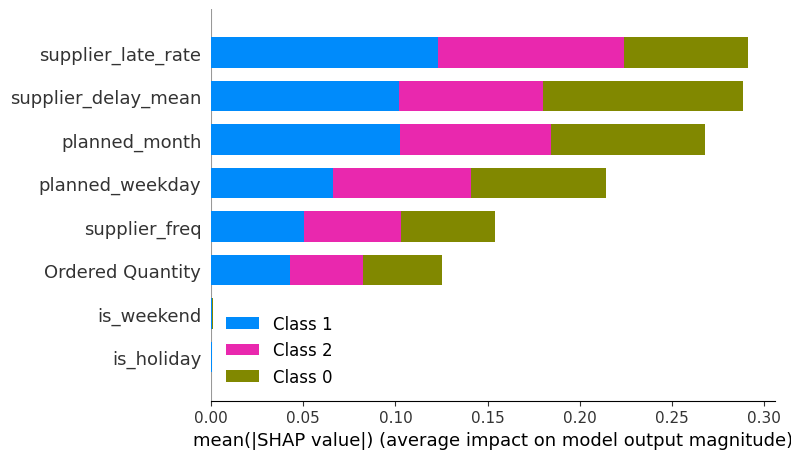

In [15]:
# SHAP Analysis: Load Model from Disk (Optimized)
# 1. Define the path
MODEL_PATH = repo_root / "outputs" / "models" / "best_a_delivery.pkl"

if MODEL_PATH.exists():
    print(f"Loading model from: {MODEL_PATH}")
    loaded_model_a_delivery = joblib.load(MODEL_PATH)
    
    # 2. Prepare the data
    features_delivery = [
        "Ordered Quantity", "planned_month", "planned_weekday",
        "is_weekend", "is_holiday", "supplier_freq",
        "supplier_delay_mean", "supplier_late_rate"
    ]

    if 'train_a_delivery' in locals():
        # Prepare the full dataset first
        X_full = train_a_delivery[features_delivery].fillna(0).astype(float)
        
        # --- OPTIMIZATION START ---
        # Instead of using all thousands of rows, we sample 500 random rows.
        # This reduces calculation time from minutes to seconds without losing accuracy in importance ranking.
        SAMPLE_SIZE = 500
        
        if len(X_full) > SAMPLE_SIZE:
            print(f"⚡ Optimizing: Downsampling data from {len(X_full)} to {SAMPLE_SIZE} for fast SHAP calculation...")
            X_shap = X_full.sample(n=SAMPLE_SIZE, random_state=42)
        else:
            X_shap = X_full
        # --- OPTIMIZATION END ---

        # 3. Generate SHAP Plot
        shap_summary_bar(
            loaded_model_a_delivery, 
            X_shap,
            feature_names=features_delivery,
            title="SHAP Feature Importance – Company A Delivery Status"
        )
    else:
        print("Error: 'train_a_delivery' is not defined. Please run the Data Preparation/Cleaning cells first.")
else:
    print(f"Error: Model file not found at {MODEL_PATH}. Please run the 'Save Best Model' step first.")


In [14]:
# Obtain sample data
example_order = X_a.iloc[0].to_dict()

# Perform predictions
raw_prediction = predict_single_order(
    best_a_delivery["best_model"],  
    example_order,
    features_delivery
)

print(f"Raw prediction (Encoded): {raw_prediction}")

# Use the label_encoder stored in the dictionary for decoding
decoded_prediction = best_a_delivery["label_encoder"].inverse_transform([raw_prediction])[0]
print(f"Decoded Predicted Value (Decoded): {decoded_prediction}")

Raw prediction (Encoded): 0
Decoded Predicted Value (Decoded): Early


## Summary & Next Steps

This notebook demonstrates a complete, modular, and reproducible workflow for
supply chain risk analysis.

**Key takeaways:**
- Supplier historical performance is a strong predictor of delivery risk
- Extreme dates and invalid orders must be handled explicitly
- Tree-based models outperform linear baselines
- SHAP improves transparency and trust in model outputs

**Potential extensions:**
- Regression models for delivery delay magnitude
- Inventory simulation based on predicted risks
- Cost-sensitive learning and service-level optimization